In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../lib/')
from frustration_graph import *
import pickle
import os
from tqdm import tqdm

In [2]:
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import minorminer
import dimod
import dwave.inspector

In [3]:
res_path = "../../Results/Ising_Frustrated/"

L = 40
config = np.zeros((L, L))

ratios = np.linspace(0, 1, 100)

In [4]:
qpu = DWaveSampler() #'defaults'
G_qpu = qpu.to_networkx_graph()

bqm = bqm_frustration(L=L, ratio=0)
G_BQM = dimod.to_networkx_graph(bqm)

emb = minorminer.find_embedding(G_BQM, 
                                G_qpu, 
                                threads=12)

sampler = FixedEmbeddingComposite(qpu, embedding=emb) #EmbeddingComposite(qpu)

In [6]:
res = []
i = 1
errors = 10

for ratio in tqdm(ratios):
    bqm = bqm_frustration(L, ratio, 0)
    M = []
    W = []
    W1 = []
    configs = []
    for i in range(errors):
        sampleset = sampler.sample(bqm, num_reads=50, annealing_time=1000, chain_strength=4,
                                        label=f'Ising Frustrated {i}/{ratios.size}')
        
        E_min = sampleset.first.energy
    
        for record in sampleset.record:
            if E_min == record[1]:
                for state, node in zip(record[0], sampleset.variables):
                    split = node.split('-')
                    x, y = int(split[0]), int(split[1])
                    config[x, y] = state
                
                
                #configs += [config.tolist()] * record[2]
                M += [np.abs(config.mean())] * record[2]
                W += [wall(config)] * record[2]
    
    res.append([np.mean(M), np.std(M), np.mean(W), np.std(W)])
    i += 1
    
res = np.array(res)

100%|██████████| 100/100 [1:03:46<00:00, 38.27s/it]


Text(0.5, 0, '$J_2/J_1$')

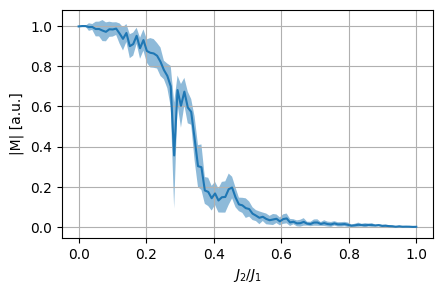

In [7]:
width = 345 * 0.013888919999994863 #5.949973986 # in inches
ratio = (np.sqrt(5.0) - 1.0) / 2.0

fig = plt.figure(figsize=(width, width * ratio))

plt.plot(ratios, res[:, 0])
plt.fill_between(ratios, res[:, 0]-res[:, 1], res[:, 0]+res[:, 1], alpha=0.5)
plt.grid()
plt.ylabel("|M| [a.u.]")
plt.xlabel(r"$J_2/J_1$")

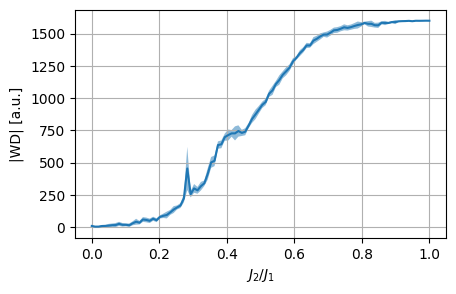

In [10]:
width = 345 * 0.013888919999994863 #5.949973986 # in inches
ratio = (np.sqrt(5.0) - 1.0) / 2.0

fig = plt.figure(figsize=(width, width * ratio))

plt.plot(ratios, res[:, 2])
plt.fill_between(ratios, res[:, 2]-res[:, 3], res[:, 2]+res[:, 3], alpha=0.5)
plt.grid()
plt.ylabel("|WD| [a.u.]")
plt.xlabel(r"$J_2/J_1$")

#plt.savefig(f"../../Images/Ising_Frustrated/WD_{L}x{L}.pdf", bbox_inches="tight")

In [9]:
np.savetxt(f'../../Results/Ising_Frustrated/DWave/Magnetizations_walls_{L}x{L}.dat', np.column_stack([ratios, res]))